Intention of this notebook is to visualize the feature importance using the SHAP library (https://github.com/slundberg/shap) of the most relevant XGBoost validation models trained on the T1626 dataset (also filtered).

You will also find the old taxonomy of the models present, however, for clarification I updated the graphs with the most recent one. Additionally you will find the corresponding current taxonomy in brakets.

## Notebook Setup

In [0]:
#Imports:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import pyplot
import pickle as pkl
import traceback
import seaborn as sns

In [0]:
#Connect to google drive:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#Set up file paths:
data_folder_loc = "gdrive/My Drive/iGEM/Databases/Merck&Co/Data/T1626/cnn_rep_sampler_T1626/"
base_data_folder_loc = "gdrive/My Drive/iGEM/Databases/Merck&Co/Data/T1626/paper_datasets_T1626/"
model_folder_loc = "gdrive/My Drive/iGEM/Databases/Merck&Co/Models/Validation_Models/"
fig_loc = "gdrive/My Drive/iGEM/Databases/Merck&Co/Validation/Feature_Importance/"

y_target_loc = base_data_folder_loc + "y_label_xgboost_T1626.csv"
X_paper_loc =  base_data_folder_loc + "X_paper_xgboost_T1626.csv"
unambiguous_sequence_mut_filter_loc = "gdrive/My Drive/iGEM/Databases/Merck&Co/Data/T1626/sequence_sampler_T1626/unambiguous_mut_filter_T1626.csv"

X_seq_all_01_loc =  data_folder_loc + "sequence_cnn_rep_all_default_01.csv"
X_seq_all_02_loc =  data_folder_loc + "sequence_cnn_rep_all_default_02.csv"
X_seq_all_03_loc =  data_folder_loc + "sequence_cnn_rep_all_default_03.csv"

parameter_table_paper_loc = "gdrive/My Drive/iGEM/Databases/Merck&Co/Models/Paper_Features_Own_Baseline/results_paper_own_baseline_xgboost_T1626.pkl"
parameter_table_seq_rep_loc = "gdrive/My Drive/iGEM/Databases/Merck&Co/Models/CNN_Features/results_default_cnn_all_01_02_03_xgboost_T1626.csv"
parameter_table_combined_loc = "gdrive/My Drive/iGEM/Databases/Merck&Co/Models/CNN_Features_Paper_Features_Combined/results_paper_cnn_all_01_02_03_xgboost_T1626.csv"

model_seq_rep_loc = model_folder_loc + "model_cnn_all_01_02_03_xgboost_T1626.pkl"
model_seq_rep_filtered_loc = model_folder_loc + "model_cnn_all_01_02_03_xgboost_T1626_filtered.pkl"
model_paper_loc = model_folder_loc + "model_paper_xgboost_T1626.pkl"
model_paper_filtered_loc = model_folder_loc + "model_paper_xgboost_T1626_filtered.pkl"
model_combined_loc = model_folder_loc + "model_paper_cnn_01_02_03_all_xgboost_T1626.pkl"
model_combined_filtered_loc = model_folder_loc + "model_paper_cnn_01_02_03_all_xgboost_T1626_filtered.pkl"

print("Folders: ")
print("\t",os.path.isdir(data_folder_loc))
print("\t",os.path.isdir(base_data_folder_loc))
print("\t",os.path.isdir(model_folder_loc))
print("\t",os.path.isdir(fig_loc))
print("Files: ")
print("\t",os.path.isfile(y_target_loc))
print("\t",os.path.isfile(X_seq_all_01_loc))
print("\t",os.path.isfile(X_seq_all_02_loc))
print("\t",os.path.isfile(X_seq_all_03_loc))
print("\t",os.path.isfile(X_paper_loc))
print("\t",os.path.isfile(unambiguous_sequence_mut_filter_loc))
print("\t",os.path.isfile(parameter_table_paper_loc))
print("\t",os.path.isfile(parameter_table_seq_rep_loc))
print("\t",os.path.isfile(parameter_table_combined_loc))

Folders: 
	 True
	 True
	 True
	 True
Files: 
	 True
	 True
	 True
	 True
	 True
	 True
	 True
	 True
	 True


In [0]:
#XGBoost
!pip install xgboost==0.82 #working GPU support
import xgboost as xgb

     |████████████████████████████████| 114.0MB 201kB/s 
  Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [0]:
#BayersianOptimization
!pip install bayesian-optimization
from bayes_opt import BayesianOptimization

  Stored in directory: /root/.cache/pip/wheels/1d/0d/3b/6b9d4477a34b3905f246ff4e7acf6aafd4cc9b77d473629b77
Successfully built bayesian-optimization


In [0]:
#SHAP FEATURE IMPORTANCE LIBRARY
!pip install shap
import shap

     |████████████████████████████████| 235kB 2.1MB/s 
  Stored in directory: /root/.cache/pip/wheels/00/20/87/d199e4d7397997f5494e4098104f91313ac8120753bee7b032
Successfully built shap


## Prepare Data

In [0]:
#Just load data
y_label = pd.read_csv(y_target_loc)["dtm"].values 
unambiguous_mut_filter = pd.read_csv(unambiguous_sequence_mut_filter_loc)["Unambiguous"].values

with open(model_seq_rep_loc, 'rb') as handle:
  model_seq_rep = pkl.load(handle)
with open(model_seq_rep_filtered_loc, 'rb') as handle:
  model_seq_rep_filtered = pkl.load(handle)
with open(model_paper_loc, 'rb') as handle:
  model_paper = pkl.load(handle)
with open(model_paper_filtered_loc, 'rb') as handle:
  model_paper_filtered = pkl.load(handle)
with open(model_combined_loc, 'rb') as handle:
  model_combined = pkl.load(handle)
with open(model_combined_filtered_loc, 'rb') as handle:
  model_combined_filtered = pkl.load(handle)

X_seq_all_01 = pd.read_csv(X_seq_all_01_loc, index_col=0)
X_seq_all_01.columns = list(map(lambda x: "layer_01_"+x, X_seq_all_01.columns))
X_seq_all_02 = pd.read_csv(X_seq_all_02_loc, index_col=0)
X_seq_all_02.columns = list(map(lambda x: "layer_02_"+x, X_seq_all_02.columns))
X_seq_all_03 = pd.read_csv(X_seq_all_03_loc, index_col=0)
X_seq_all_03.columns = list(map(lambda x: "layer_03_"+x, X_seq_all_03.columns))

X_paper = pd.read_csv(X_paper_loc) 

parameter_table_paper = pd.read_pickle(parameter_table_paper_loc)
parameter_table_seq_rep = pd.read_csv(parameter_table_seq_rep_loc, index_col="Unnamed: 0")
parameter_table_combined = pd.read_csv(parameter_table_combined_loc, index_col="Unnamed: 0")

In [0]:
X_seq_all_01_02_03 = pd.concat([X_seq_all_01, X_seq_all_02, X_seq_all_03], axis=1)
X_seq_all_01_02_03 = X_seq_all_01_02_03.reset_index(drop=True)

In [0]:
print(X_paper.shape)
print(X_seq_all_01_02_03.shape)

(1626, 158)
(1626, 5376)


In [0]:
X_paper_all_01_02_03 = pd.concat([X_seq_all_01_02_03, X_paper], axis=1)

In [0]:
print(X_paper_all_01_02_03.shape)
X_paper_all_01_02_03.head()

(1626, 5534)


,layer_01_wt_rep_0,layer_01_wt_rep_1,layer_01_wt_rep_2,layer_01_wt_rep_3,layer_01_wt_rep_4,layer_01_wt_rep_5,layer_01_wt_rep_6,layer_01_wt_rep_7,layer_01_wt_rep_8,layer_01_wt_rep_9,layer_01_wt_rep_10,layer_01_wt_rep_11,layer_01_wt_rep_12,layer_01_wt_rep_13,layer_01_wt_rep_14,layer_01_wt_rep_15,layer_01_wt_rep_16,layer_01_wt_rep_17,layer_01_wt_rep_18,layer_01_wt_rep_19,layer_01_wt_rep_20,layer_01_wt_rep_21,layer_01_wt_rep_22,layer_01_wt_rep_23,layer_01_wt_rep_24,layer_01_wt_rep_25,layer_01_wt_rep_26,layer_01_wt_rep_27,layer_01_wt_rep_28,layer_01_wt_rep_29,layer_01_wt_rep_30,layer_01_wt_rep_31,layer_01_wt_rep_32,layer_01_wt_rep_33,layer_01_wt_rep_34,layer_01_wt_rep_35,layer_01_wt_rep_36,layer_01_wt_rep_37,layer_01_wt_rep_38,layer_01_wt_rep_39,...,mono_fa_intra_rep,mono_fa_pair,mono_fa_rep,mono_fa_sol,mono_hbond_bb_sc,mono_hbond_lr_bb,mono_hbond_sc,mono_hbond_sr_bb,mono_omega,mono_p_aa_pp,mono_pro_close,mono_rama,mono_ref,mutability_diff,mutability_first,mutability_second,pi_diff,pi_first,pi_second,polarity2_diff,polarity2_first,polarity2_second,polarity_diff,polarity_first,polarity_second,r_bioluminate_delta_stability,r_bioluminate_delta_stability_coulomb,r_bioluminate_delta_stability_covalent,r_bioluminate_delta_stability_hbond,r_bioluminate_delta_stability_lipo,r_bioluminate_delta_stability_packing,r_bioluminate_delta_stability_reference,r_bioluminate_delta_stability_selfcont,r_bioluminate_delta_stability_solv_gb,r_bioluminate_delta_stability_solv_sa,r_bioluminate_delta_stability_vdw,totalarea,vdw_vol_diff,vdw_vol_first,vdw_vol_second
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.017,0.676,1.218,0.849,-0.308,0.025,-0.004,0.580,0.510,-0.156,-0.022,0.080,0.39,-55,96,41,-0.46,5.94,5.48,0.0,5.2,5.2,0.22,0.13,0.35,57.190568,-5.247211,16.962505,0.001455,-1.780960,-0.222214,11.97,0.000000,0.048306,0,35.458685,352.854,11.7,44.4,56.1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.003,-0.063,0.791,1.978,0.518,-0.215,-0.139,-0.086,-0.341,0.092,0.107,0.042,0.22,-28,134,106,-2.64,5.41,2.77,1.4,11.6,13.0,46.32,3.38,49.70,6.814512,26.015488,-2.211351,-0.703686,-0.023160,0.000000,-2.59,1.809311,-15.125860,0,-0.356230,250.477,-2.7,32.7,30.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.006,-0.006,0.315,1.899,0.394,-0.122,-0.254,0.318,-0.388,-0.199,0.030,-0.266,0.16,9,93,102,-2.43,5.65,3.22,1.8,10.5,12.3,46.37,3.53,49.90,-0.244040,27.267716,5.419830,0.727414,0.396678,0.000000,-15.50,1.497642,-20.868415,0,0.815094,237.956,-2.5,42.7,40.2
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.011,-0.044,0.236,-0.390,-0.258,0.061,2.640,-0.148,-0.446,-0.798,-0.012,-0.199,0.83,-31,97,66,1.83,5.64,7.47,1.8,8.6,10.4,49.94,1.66,51.60,-0.677061,-8.077659,6.637486,-0.173612,0.095144,-0.715138,-2.29,4.308097,2.411324,0,-2.872702,249.997,16.6,28.5,45.1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.013,0.222,0.642,1.757,-0.148,0.085,0.106,0.380,-0.277,-0.191,-0.010,-0.070,0.83,-31,97,66,1.83,5.64,7.47,1.8,8.6,10.4,49.94,1.66,51.60,-2.417276,-4.684038,2.152989,0.008213,0.528266,-0.004608,0.23,3.777104,-1.869512,0,-2.555690,204.059,16.6,28.5,45.1


In [0]:
str(list(X_paper_all_01_02_03.columns))

"['layer_01_wt_rep_0', 'layer_01_wt_rep_1', 'layer_01_wt_rep_2', 'layer_01_wt_rep_3', 'layer_01_wt_rep_4', 'layer_01_wt_rep_5', 'layer_01_wt_rep_6', 'layer_01_wt_rep_7', 'layer_01_wt_rep_8', 'layer_01_wt_rep_9', 'layer_01_wt_rep_10', 'layer_01_wt_rep_11', 'layer_01_wt_rep_12', 'layer_01_wt_rep_13', 'layer_01_wt_rep_14', 'layer_01_wt_rep_15', 'layer_01_wt_rep_16', 'layer_01_wt_rep_17', 'layer_01_wt_rep_18', 'layer_01_wt_rep_19', 'layer_01_wt_rep_20', 'layer_01_wt_rep_21', 'layer_01_wt_rep_22', 'layer_01_wt_rep_23', 'layer_01_wt_rep_24', 'layer_01_wt_rep_25', 'layer_01_wt_rep_26', 'layer_01_wt_rep_27', 'layer_01_wt_rep_28', 'layer_01_wt_rep_29', 'layer_01_wt_rep_30', 'layer_01_wt_rep_31', 'layer_01_wt_rep_32', 'layer_01_wt_rep_33', 'layer_01_wt_rep_34', 'layer_01_wt_rep_35', 'layer_01_wt_rep_36', 'layer_01_wt_rep_37', 'layer_01_wt_rep_38', 'layer_01_wt_rep_39', 'layer_01_wt_rep_40', 'layer_01_wt_rep_41', 'layer_01_wt_rep_42', 'layer_01_wt_rep_43', 'layer_01_wt_rep_44', 'layer_01_wt_rep_4

## Supplementary functions

In [0]:
def plot_default_feature_importance(model, title, save_loc):
  sns.set()
  fig, ax = plt.subplots(figsize=(8,6))
  xgb.plot_importance(model, max_num_features=20, ax=ax)
  ax.set_title(title)
  plt.tight_layout()
  plt.savefig(save_loc, dpi=300)
  plt.show()

In [0]:
def plot_shap_feature_importance(model, data, title, save_loc):
  sns.set()
  shap.initjs() # load JS visualization code to notebook
  explainer = shap.TreeExplainer(model)
  shap_values = explainer.shap_values(data)
  plt.figure(figsize=(12,10))
  shap.summary_plot(shap_values, data, show=False,auto_size_plot=False) 
  plt.title(title)
  plt.tight_layout()
  plt.savefig(save_loc, dpi=300)
  plt.show()

## Visualize feature importances

### Model paper (S_E)

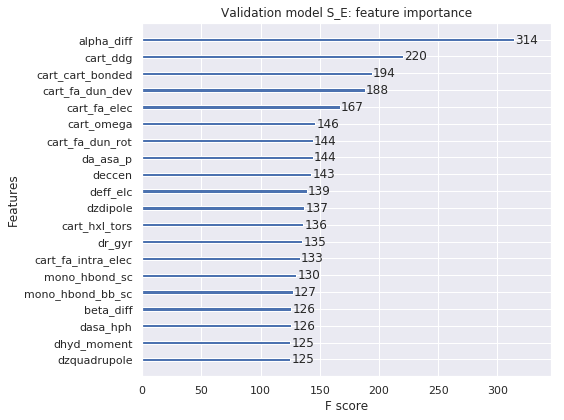

In [0]:
plot_default_feature_importance(model=model_paper, title="Validation model S_E: feature importance", save_loc=fig_loc+"validation_model_paper_feature_importance_NEW.png")

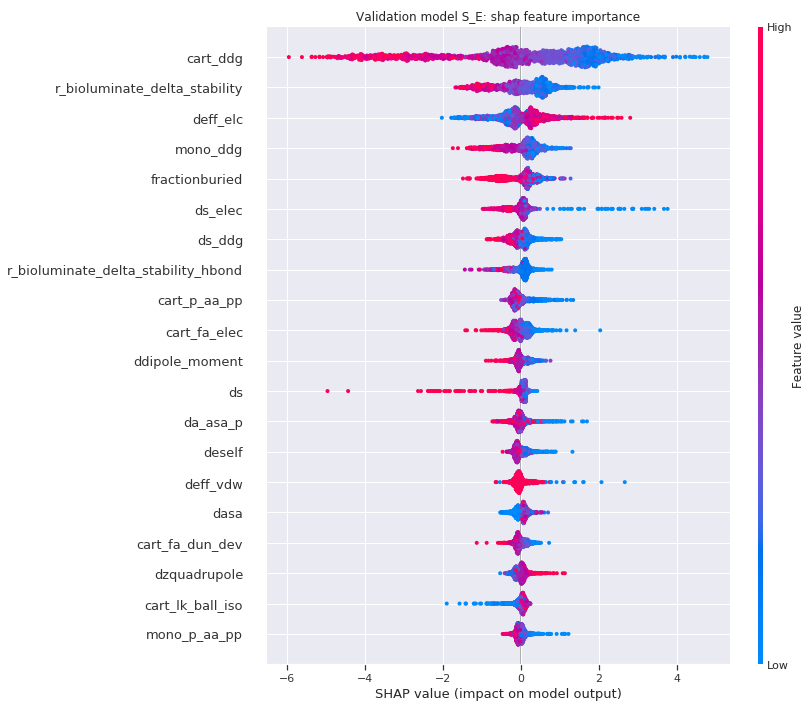

In [0]:
plot_shap_feature_importance(model=model_paper, data=X_paper, title="Validation model S_E: shap feature importance", save_loc=fig_loc+"validation_model_paper_feature_importance_shap_NEW.png")

### Model seq_rep (A13)

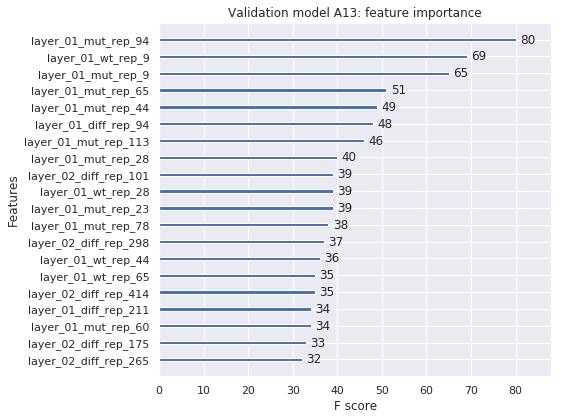

In [0]:
plot_default_feature_importance(model=model_seq_rep, title="Validation model A13: feature importance", save_loc=fig_loc+"validation_model_seq_rep_feature_importance_NEW.png")

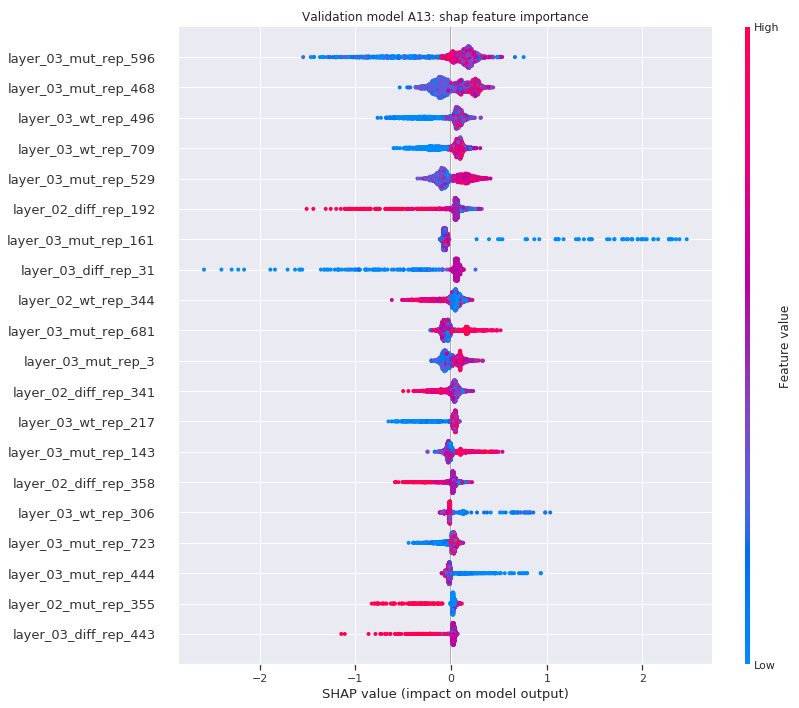

In [0]:
plot_shap_feature_importance(model=model_seq_rep, data=X_seq_all_01_02_03, title="Validation model A13: shap feature importance", save_loc=fig_loc+"validation_model_seq_rep_feature_importance_shap_NEW.png")

### Model paper cnn 01 02 03 all (S_E_A13)

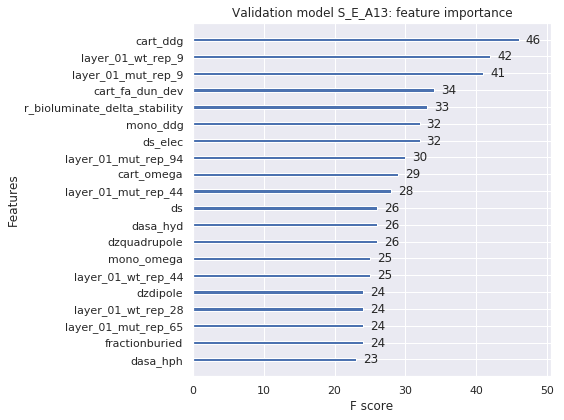

In [0]:
plot_default_feature_importance(model=model_combined, title="Validation model S_E_A13: feature importance", save_loc=fig_loc+"validation_model_combined_feature_importance_NEW.png")

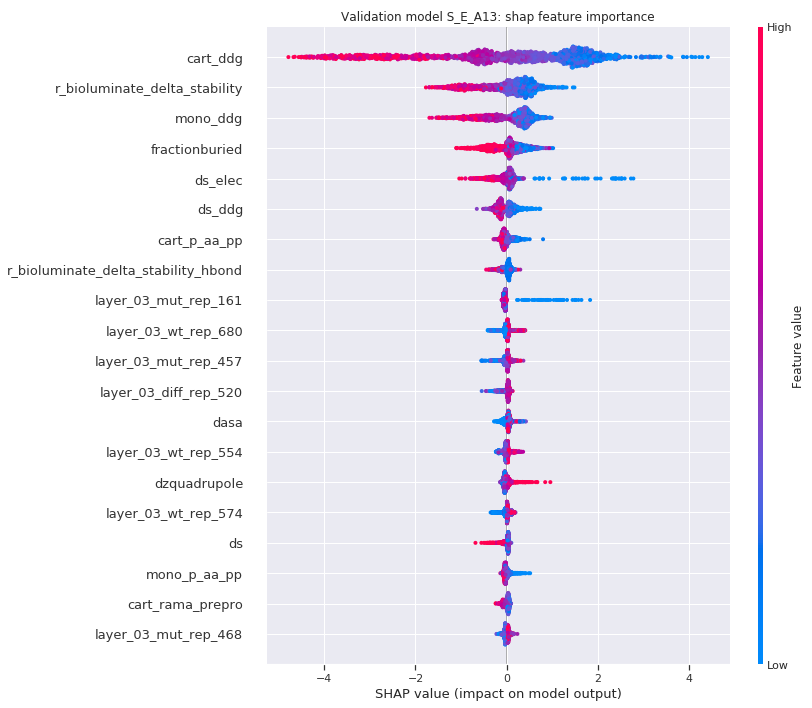

In [0]:
plot_shap_feature_importance(model=model_combined, data=X_paper_all_01_02_03, title="Validation model S_E_A13: shap feature importance", save_loc=fig_loc+"validation_model_combined_feature_importance_shap_NEW.png")